In [449]:
import shap
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from datetime import datetime
from pandasql import sqldf
from optbinning import OptimalBinning
from optbinning import BinningProcess
import xgboost as xgb
from xgboost import XGBClassifier
import scipy.stats as stats
from imblearn.under_sampling import RandomUnderSampler
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
import keras_tuner as kt
from keras_tuner import Hyperband
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score ,recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, auc as sklearn_auc
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

import warnings
warnings.filterwarnings("ignore")
seed = 1

In [226]:
path = "C:/Users/danil/Desktop/Case Mercado Livre/Files/"
file_1 = "full_devices.csv"
data_1 = pd.read_csv(path+file_1, encoding='cp1252')
df = data_1.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by =['device', 'date']).reset_index(drop=True) #Ordenando por device e data

# Análise Inicial

In [1796]:
#Análise inicial
profile = ProfileReport(df, title = "EDA report", progress_bar = False)
profile.to_notebook_iframe()

## Considerações

1. O dataset possui um severo desbalanceamento, com menos de 1% de eventos de falha (106 de 124.494);
2. A variável devices é composta por 1169 dispositivos únicos. Como pode ser visto na núvem de palavras, o número de observações por device não é constante;
3. O período coberto pelo dataset é de 01-01-2015 à 02-11-2015;
4. O dataset não possui valores faltantes, porém possui uma linha duplicada;
5. Todas as variáveis de attribute são numéricas e positivas;
6. As variáveis attribute3 e 9 possuem correlação acima de 0,3;
7. As variáveis attribute7 e 8 são iguais (mesmos valores mínimos, máximos e média, além de correlação = 1);
8. A variável attribute1 possui valores altos (média = 1.223881 × 10^8) e distribuição uniforme;
9. As variáveis attribute2, 3, 4, 7 e 8 são majoritariamanete compostas por 0 (acima de 92%).

## Tratativas Iniciais

Inicialmente, será removida uma das variáveis duplicadas (attribute 8), assim como a observação duplicada.

Tendo em vista que o objetivo do modelo é estimar a probabilidade de falha em d+1, utilizando como variável explicativa uma série temporal das variáveis de comportamento, será feito o deslocamento (shift) da variável failure em -1. Além disso, para que o histórico do dispositivo seja utilizado como variável, serão criadas novas variáveis defasadas com as observações passadas.

A janela de criação dessas variáveis de histórico será definida conforme o menor número de observações encontradas por dispositivo. Vale ressaltar que, devido à defasagem da variável de falha, a última observação de cada dispositivo será descartada.

Dois pontos que devem ser considerados aqui são a separação por dispositivos e os possíveis saltos entre períodos.

Como estamos observando diferentes dispositivos, a criação das variáveis precisa ser feita individualmente, garantindo que não ocorra a combinação de comportamentos. Em relação aos saltos temporais, se as observações forem interrompidas e retomadas N dias depois, isso afetará não apenas o histórico registrado, mas também a falha apontada. Para validar os impactos desse cenário, serão testadas duas abordagens:

- Não será permitida a utilização de variáveis que apresentem saltos temporais. Dessa forma, sempre que ocorrer um salto, as observações afetadas serão removidas (uma observação anterior ao período afetado, devido à defasagem da falha, e N observações após o período, sendo N a janela definida para a defasagem das variáveis).

- Em vez de remover todas as observações afetadas, apenas a variável imediatamente anterior ao período observado será removida (devido à defasagem do evento). Para as variáveis posteriores, os valores faltantes serão preenchidos com 0.

Vale ressaltar que esse segundo cenário é mais próximo do que seria encontrado na prática.

In [198]:
#Remoção de colunas e observações duplicadas
df.drop(['attribute8'], axis=1, inplace = True)
df.drop_duplicates(inplace = True, ignore_index = True)

#Menor janela de dados por observação
window_df = df.groupby(["device"]).agg(serie_size = ("device", lambda x: x.count()),
                                fail = ('failure', lambda x: x.sum())).reset_index()

#Visualização da Janela
display(window_df.loc[window_df["fail"] == 1,].sort_values(by='serie_size').head(1))
janela = window_df.loc[window_df["fail"] == 1,].sort_values(by='serie_size')['serie_size'][:1].values[0] - 1

device  serie_size  fail
239  S1F0RRB1           5     1

Hipótese inicial - Usar como janela geral a menor janela até a falha encontrada nos dados, no caso 5 observações passadas para prever o próximo dia.

#### Transformação dos dados para ambos os cenários

In [181]:
def query_gen(df, var_list, date_var, y, window, drop=True):
    # Gerar as colunas base
    colunas = ",\n".join([f"a.{var}" for var in var_list])

    # Gerar os atributos com o sufixo "_d_X", onde X é o número da janela
    atributos = ",\n".join([f"d{w_count}.{var} as {var}_d_{w_count}"
                            for var in var_list
                            for w_count in range(1, window + 1)])

    # Gerar os left joins para cada janela de tempo
    l_join = "\n".join([f"left join {df} as d{w_count} "
                        f"on a.device = d{w_count}.device "
                        f"and julianday(date(a.date)) - julianday(date(d{w_count}.date)) = {w_count}"
                        for w_count in range(1, window + 1)])
    
    # Condição adicional quando o parâmetro 'drop' for True
    if drop:
        wr = " ".join([f"and d{w_count}.attribute1 is not null" for w_count in range(1, window + 1)])
    else:
        wr = ''

    # Retornar a query final formatada
    return f'''
        select a.date, a.device, {colunas}, f.failure as rolled_failure, {atributos}
        from {df} as a
        {l_join}
        left join {df} as f 
        on a.device = f.device 
        and julianday(date(a.date)) - julianday(date(f.date)) = -1
        where f.failure is not null {wr}
    '''

In [199]:
#Criação do dataset - Cenário 1 (Removendo saltos temporais)
vars = [item for item in df.columns if item.startswith('attribute')]
df_cenario_1 = sqldf(query_gen('df', vars, 'date', 'failure', janela, drop = True)).fillna(0)

#Criação do dataset - Cenário 2 (Mantendo saltos temporais)
df_cenario_2 = sqldf(query_gen('df', vars, 'date', 'failure', janela, drop = False)).fillna(0)

# Aplicando a transformação logarítmica com o valor pequeno adicionado
# Definindo o valor pequeno para evitar o log de zero
small_constant = 1e-6

for df in [df_cenario_1, df_cenario_2]:
    vars = [item for item in df.columns if item.startswith('attribute')]
    df[vars] = np.log(df[vars] + small_constant)

# Cenário 1 - Saltos temporais removidos

## Aplicação do Optbinning (Information Value) e teste de Kolmogorov-Smirnov (KS) para seleção de features

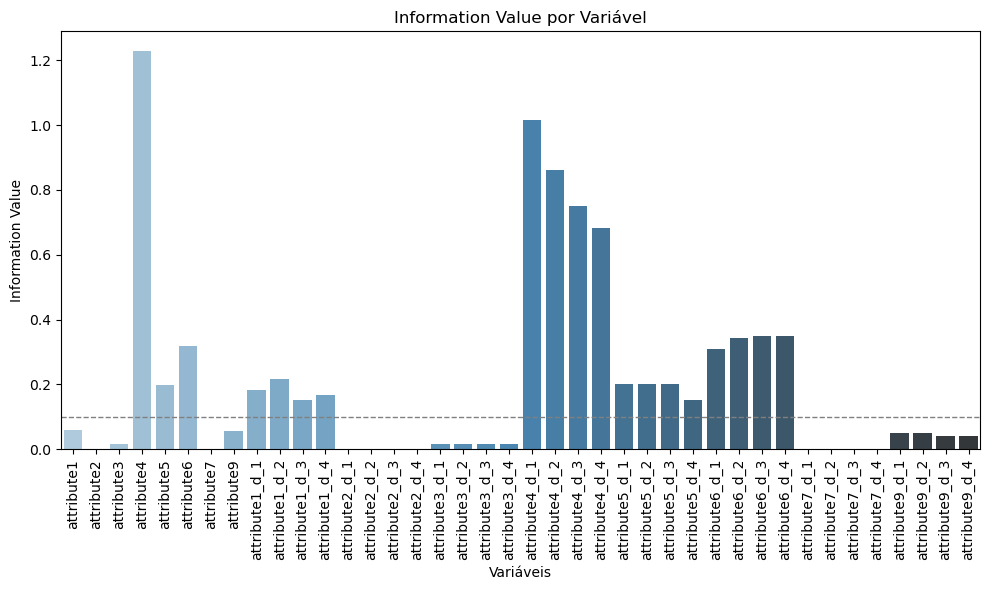

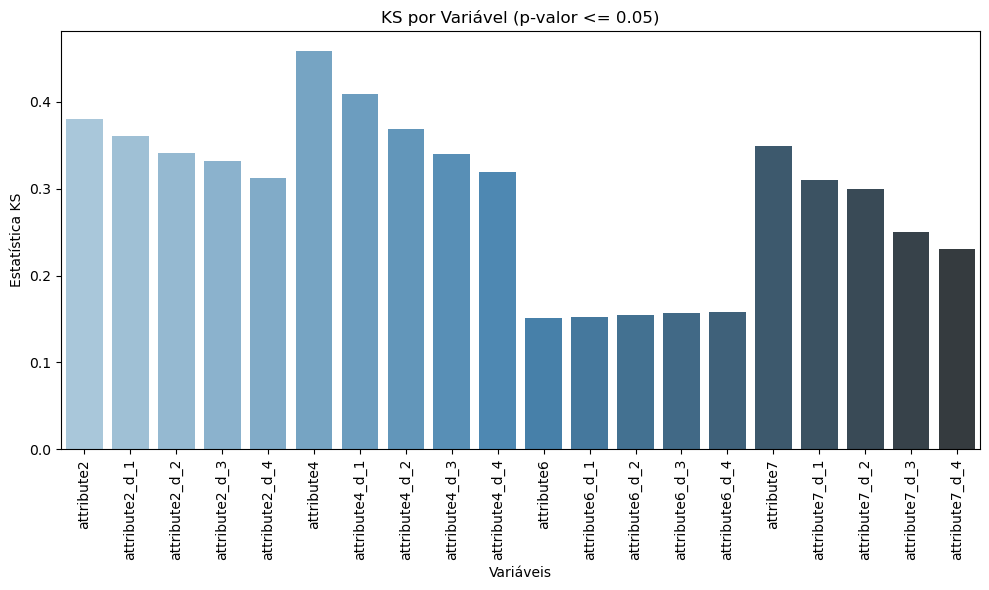

In [297]:
# Lista para armazenar os Information Values (IV) das variáveis
iv_values = []
variable_names = [item for item in df_cenario_1.columns if item.startswith('attribute')]

# Calcula o IV para cada variável
for i in range(len(variable_names)):
    iv = binning[i].binning_table.iv
    iv_values.append(iv)

# Criação do gráfico de barras para Information Value
plt.figure(figsize=(10, 6))
sns.barplot(x=variable_names, y=iv_values, palette="Blues_d")
plt.axhline(y=0.1, color='gray', linestyle='--', linewidth=1)
plt.xticks(rotation=90)
plt.title('Information Value por Variável')
plt.xlabel('Variáveis')
plt.ylabel('Information Value')
plt.tight_layout()

# Seleção de features usando o Teste de Kolmogorov-Smirnov
ks_var, ks_values, ks_p = [], [], []

for _var in vars:
    grupo_0 = df_cenario_1.loc[df_cenario_1["rolled_failure"] == 0, _var]
    grupo_1 = df_cenario_1.loc[df_cenario_1["rolled_failure"] == 1, _var]

    # Aplica o Teste de Kolmogorov-Smirnov
    ks_stat, p_value = stats.ks_2samp(grupo_0, grupo_1)
    
    if p_value <= 0.05:
        ks_var.append(_var)
        ks_values.append(ks_stat)
        ks_p.append(p_value)

# Criação do gráfico de barras para KS
plt.figure(figsize=(10, 6))
sns.barplot(x=ks_var, y=ks_values, palette="Blues_d")
plt.xticks(rotation=90)
plt.title('KS por Variável (p-valor <= 0.05)')
plt.xlabel('Variáveis')
plt.ylabel('Estatística KS')
plt.tight_layout()
plt.show()

In [300]:
vars_escolhidas = ['attribute2', 'attribute2_d_1', 'attribute2_d_2', 'attribute2_d_3', 'attribute2_d_4',
         'attribute4', 'attribute4_d_1', 'attribute4_d_2', 'attribute4_d_3', 'attribute4_d_4',
         'attribute6', 'attribute6_d_1', 'attribute6_d_2', 'attribute6_d_3', 'attribute6_d_4',
         'attribute7', 'attribute7_d_1', 'attribute7_d_2', 'attribute7_d_3', 'attribute7_d_4']

Como critério inicial, foram consideradas todas as variáveis com um Information Value (IV) maior que 0,1. Além do IV, foi aplicado o teste de Kolmogorov-Smirnov (KS) para verificar se existem diferenças significativas entre as distribuições das variáveis em relação a eventos e não eventos.

Embora as variáveis attribute1 e attribute5 tenham apresentado IV superior a 0,1, a análise do teste de KS não encontrou evidências que confirmassem diferenças entre as distribuições na presença e na ausência de eventos. Por outro lado, embora as variáveis attribute2 e attribute7 não tenham apresentado IV superior a 0,1, o teste de KS indicou que existem evidências de que as distribuições dessas variáveis diferem na presença e na ausência de eventos. Assim, as variáveis selecionadas para modelagem são attribute2, attribute4, attribute6, attribute7 e suas respectivas variáveis derivadas.

## Amostragem com auxílio do KMeans e balanceamento dos dados (undersampling)

Para a modelagem, será adotada uma abordagem de 75/25, onde 75% dos dados serão utilizados para treinar o modelo (com a aplicação de cross-validation) e 25% para validação (out-of-sample). Como as variáveis utilizadas no modelo são integralmente numéricas, não será possível aplicar boas práticas de experimento e controle de viés, que costumam utilizar variáveis categóricas para isso.

Para mitigar esse problema, será utilizado o método de agrupamento KMeans como uma solução paliativa. A solução será composta pelos seguintes passos:

1. Separação entre eventos e não eventos;
2. Aplicação do método KMeans para criação de clusters, utilizando as variáveis selecionadas anteriormente;
3. Amostragem estratificada pela variável de cluster dos conjuntos de eventos e não eventos, bem como a separação 25/75 de cada conjunto;
4. Reagrupamento dos conjuntos, formando a partição de treino e a de teste.

Após esse procedimento, será aplicado o método de balanceamento Undersampling ao conjunto de treino, visando uma distribuição equilibrada de 50% para cada classe.

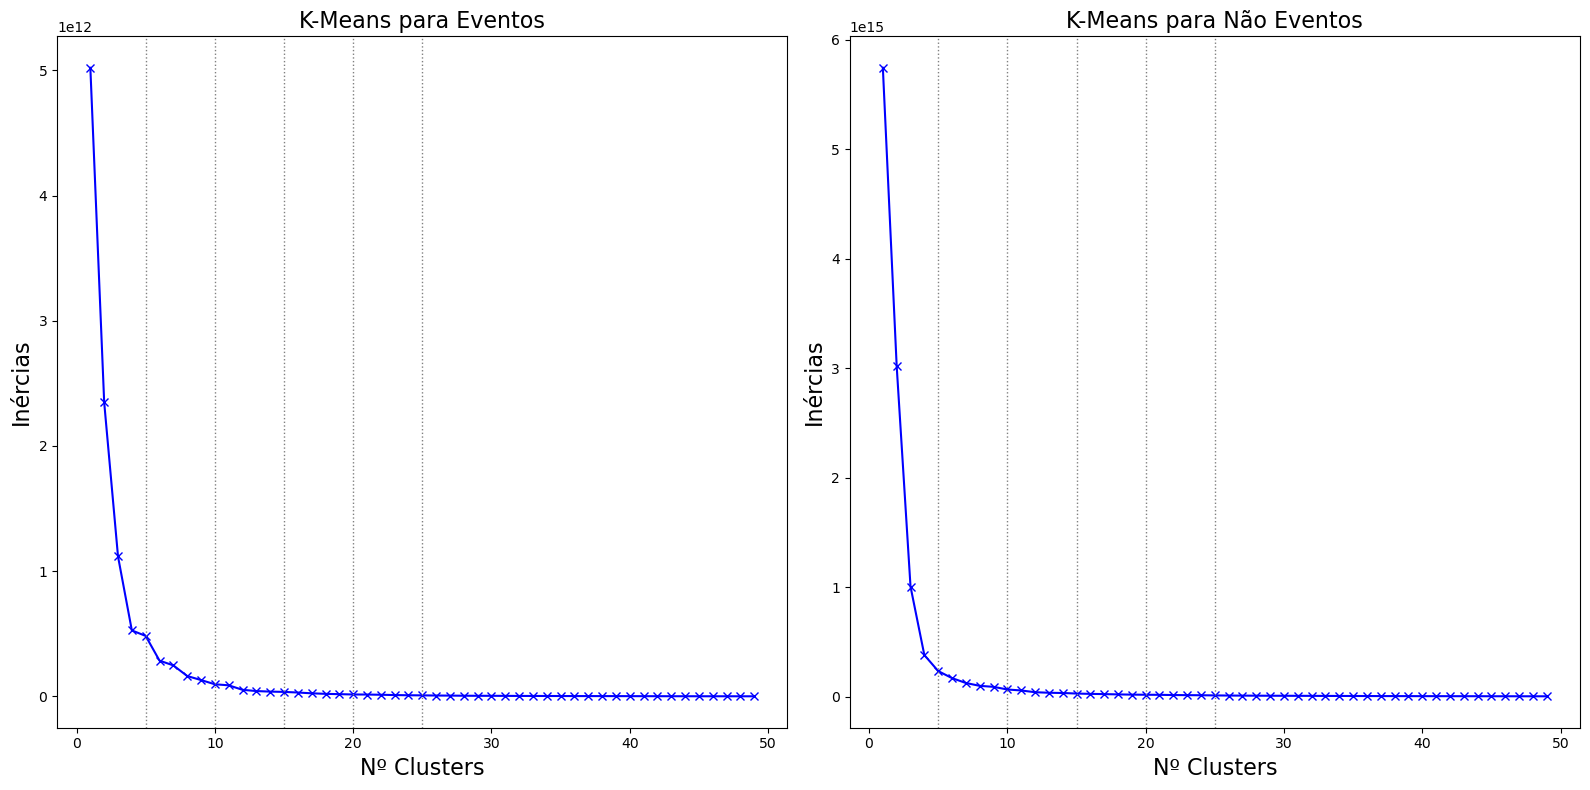

In [393]:
df_kmeans = df_cenario_1.copy()
df_eventos = df_kmeans.loc[df_kmeans['rolled_failure'] == 1,]
df_n_eventos = df_kmeans.copy().loc[df_kmeans['rolled_failure'] == 0,]

# Criar uma figura com 2 subplots lado a lado
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Lista de DataFrames e títulos para os gráficos
dataframes = [df_eventos, df_n_eventos]
titles = ['K-Means para Eventos', 'K-Means para Não Eventos']

for i, df in enumerate(dataframes):
    inercias = []
    K = range(1, 50)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=seed).fit(df[vars_escolhidas])
        inercias.append(kmeanModel.inertia_)
    
    # Plotar a inércia
    axs[i].plot(K, inercias, 'bx-')
    axs[i].axvline(x=5, color='grey', linestyle=':', linewidth=1)
    axs[i].axvline(x=10, color='grey', linestyle=':', linewidth=1)
    axs[i].axvline(x=15, color='grey', linestyle=':', linewidth=1)
    axs[i].axvline(x=20, color='grey', linestyle=':', linewidth=1)
    axs[i].axvline(x=25, color='grey', linestyle=':', linewidth=1)
    
    # Adicionar rótulos e título
    axs[i].set_xlabel('Nº Clusters', fontsize=16)
    axs[i].set_ylabel('Inércias', fontsize=16)
    axs[i].set_title(titles[i], fontsize=16)
plt.tight_layout()
plt.show()

In [373]:
#Balanceamento e separação dos conjuntos
clusters = 5

# Separar os eventos (failures) e não eventos
df_n_eventos = df_cenario_1.loc[df_cenario_1['rolled_failure'] == 0].copy()
df_eventos = df_cenario_1.loc[df_cenario_1['rolled_failure'] == 1].copy()

# Aplicar KMeans aos não eventos
kmeans_n_eventos = KMeans(n_clusters=clusters, random_state=seed).fit(df_n_eventos[vars_escolhidas])
df_n_eventos["clusters"] = kmeans_n_eventos.labels_

# Aplicar KMeans aos eventos
kmeans_eventos = KMeans(n_clusters=clusters, random_state=seed).fit(df_eventos[vars_escolhidas])
df_eventos["clusters"] = kmeans_eventos.labels_

# Dividir os eventos em treino (75%) e teste (25%)
df_eventos_teste = df_eventos.groupby('clusters', group_keys=False).apply(lambda x: x.sample(frac=0.25, random_state=seed))
df_eventos_treino = df_eventos.drop(df_eventos_teste.index)
df_eventos_teste = df_eventos_teste.drop(['clusters'], axis=1)
df_eventos_treino = df_eventos_treino.drop(['clusters'], axis=1)

# Dividir os não eventos em treino (75%) e teste (25%)
df_n_eventos_teste = df_n_eventos.groupby('clusters', group_keys=False).apply(lambda x: x.sample(frac=0.25, random_state=seed))
df_n_eventos_treino = df_n_eventos.drop(df_n_eventos_teste.index)
df_n_eventos_teste = df_n_eventos_teste.drop(['clusters'], axis=1)
df_n_eventos_treino = df_n_eventos_treino.drop(['clusters'], axis=1)

# Concatenar os dados de treino e teste
df_teste = pd.concat([df_n_eventos_teste, df_eventos_teste])
df_treino = pd.concat([df_n_eventos_treino, df_eventos_treino])

# Criação dos conjuntos
X_test = df_teste[vars_escolhidas]
y_test = df_teste['rolled_failure']

X_train = df_treino[vars_escolhidas]
y_train = df_treino['rolled_failure']

# Aplicar RandomUnderSampler para balancear a classe minoritária
undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state=seed)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

## XGBoosting

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Média da AUC ROC CV = 5: 0.8669 (±0.0556)
Acurácia de treino: 0.8756
Threshold ótimo: 0.4566
Recall Otimizado: 0.7200


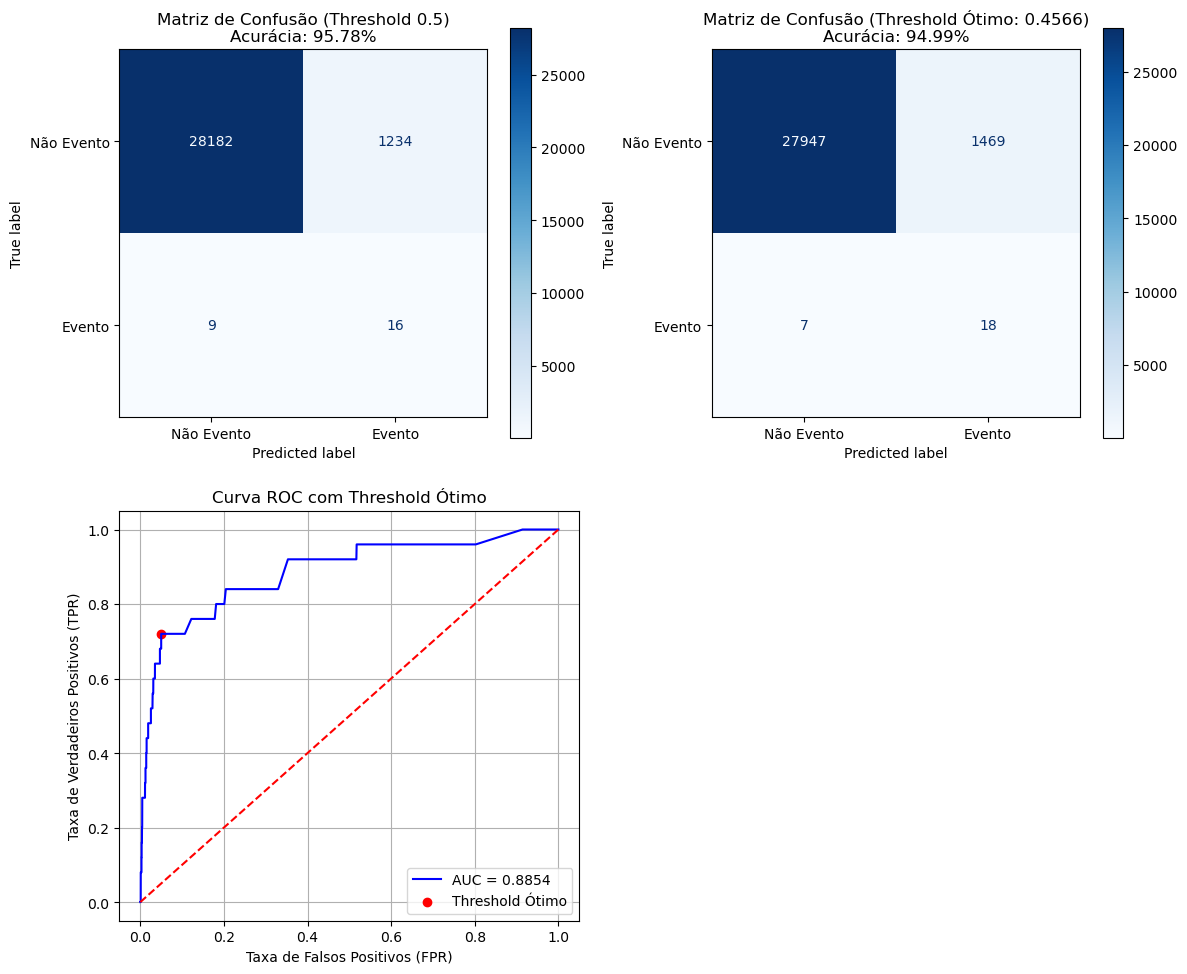

In [374]:
# Parâmetros para otimização
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}

# Instanciar o XGBoostClassifier
XGB1_model = XGBClassifier(random_state=seed)

# GridSearchCV para otimização de parâmetros
XGB1_grid_search = GridSearchCV(estimator=XGB1_model, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
XGB1_grid_search.fit(X_resampled, y_resampled)

# Obter o melhor modelo
XGB1_best_model = XGB1_grid_search.best_estimator_

# Avaliar a média e desvio padrão da AUC ROC para o melhor modelo
XGB1_mean_auc = XGB1_grid_search.cv_results_['mean_test_score'][XGB1_grid_search.best_index_]
XGB1_std_auc = XGB1_grid_search.cv_results_['std_test_score'][XGB1_grid_search.best_index_]

# Exibir resultados
print(f"Média da AUC ROC CV = 5: {XGB1_mean_auc:.4f} (±{XGB1_std_auc:.4f})")
print(f"Acurácia de treino: {XGB1_best_model.score(X_resampled, y_resampled):.4f}")

# Previsões no conjunto de teste com threshold padrão (0.5)
XGB1_y_pred = XGB1_best_model.predict(X_test)
XGB1_cm_default = confusion_matrix(y_test, XGB1_y_pred)
XGB1_accuracy_default = accuracy_score(y_test, XGB1_y_pred)

# Previsões de probabilidades no conjunto de teste
XGB1_y_prob = XGB1_best_model.predict_proba(X_test)[:, 1]
XGB1_fpr, XGB1_tpr, XGB1_thresholds = roc_curve(y_test, XGB1_y_prob)
XGB1_auc = roc_auc_score(y_test, XGB1_y_prob)

# Encontrar o threshold ótimo que maximiza a soma de TPR e (1-FPR)
XGB1_optimal_idx = np.argmax(XGB1_tpr - XGB1_fpr)
XGB1_optimal_threshold = XGB1_thresholds[XGB1_optimal_idx]
print(f"Threshold ótimo: {XGB1_optimal_threshold:.4f}")

# Previsões com o threshold otimizado
XGB1_y_pred_optimal = (XGB1_y_prob >= XGB1_optimal_threshold).astype(int)
XGB1_cm_optimal = confusion_matrix(y_test, XGB1_y_pred_optimal)
XGB1_accuracy_optimal = accuracy_score(y_test, XGB1_y_pred_optimal)
print(f'Recall Otimizado: {recall_score(y_test, XGB1_y_pred_optimal):.4f}')

# Criar subplots para exibir as matrizes de confusão e a curva ROC
XGB1_fig, XGB1_axes = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1]})

# Matriz de confusão com threshold 0.5
ConfusionMatrixDisplay(confusion_matrix=XGB1_cm_default, display_labels=['Não Evento', 'Evento']).plot(ax=XGB1_axes[0, 0], cmap='Blues', values_format='d')
XGB1_axes[0, 0].set_title(f'Matriz de Confusão (Threshold 0.5)\nAcurácia: {XGB1_accuracy_default * 100:.2f}%')

# Matriz de confusão com threshold otimizado
ConfusionMatrixDisplay(confusion_matrix=XGB1_cm_optimal, display_labels=['Não Evento', 'Evento']).plot(ax=XGB1_axes[0, 1], cmap='Blues', values_format='d')
XGB1_axes[0, 1].set_title(f'Matriz de Confusão (Threshold Ótimo: {XGB1_optimal_threshold:.4f})\nAcurácia: {XGB1_accuracy_optimal * 100:.2f}%')

# Curva ROC com o threshold ótimo
XGB1_axes[1, 0].plot(XGB1_fpr, XGB1_tpr, color='blue', label=f'AUC = {XGB1_auc:.4f}')
XGB1_axes[1, 0].scatter(XGB1_fpr[XGB1_optimal_idx], XGB1_tpr[XGB1_optimal_idx], marker='o', color='red', label='Threshold Ótimo')
XGB1_axes[1, 0].plot([0, 1], [0, 1], color='red', linestyle='--')
XGB1_axes[1, 0].set_xlabel('Taxa de Falsos Positivos (FPR)')
XGB1_axes[1, 0].set_ylabel('Taxa de Verdadeiros Positivos (TPR)')
XGB1_axes[1, 0].set_title('Curva ROC com Threshold Ótimo')
XGB1_axes[1, 0].legend(loc='lower right')
XGB1_axes[1, 0].grid()
XGB1_fig.delaxes(XGB1_axes[1, 1])
plt.tight_layout()
plt.show()

## Regressão Logística

Média da AUC ROC CV = 5: 0.7205 (±0.0928)
Acurácia de treino: 0.8489
Threshold ótimo: 0.3815
Recall Otimizado: 0.7200


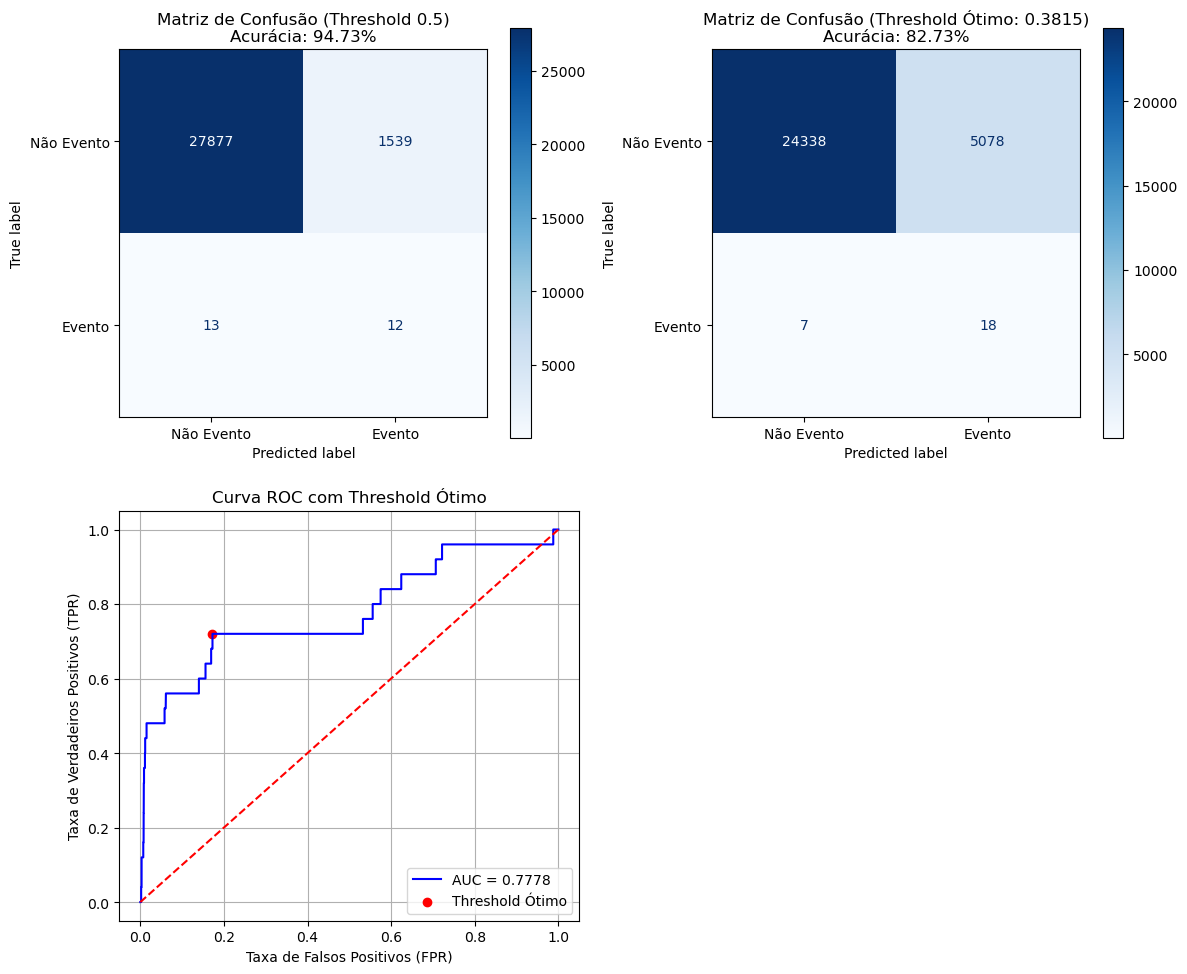

In [365]:
# Definir o modelo de regressão logística
LR1_model = LogisticRegression(random_state=seed, solver='liblinear', class_weight='balanced')

# Implementar K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
LR1_cross_val_scores = cross_val_score(LR1_model, X_resampled, y_resampled, cv=kf, scoring='roc_auc')

print(f"Média da AUC ROC CV = 5: {LR1_cross_val_scores.mean():.4f} (±{LR1_cross_val_scores.std():.4f})")

# Treinar o modelo no conjunto de dados resampled
LR1_model.fit(X_resampled, y_resampled)
LR1_y_pred = LR1_model.predict(X_test)

# Calcular a acurácia e exibir a matriz de confusão com threshold padrão (0.5)
LR1_cm_default = confusion_matrix(y_test, LR1_y_pred)
LR1_accuracy_default = accuracy_score(y_test, LR1_y_pred)

# Fazer previsões de probabilidades no conjunto de teste
LR1_y_prob = LR1_model.predict_proba(X_test)[:, 1]

# Calcular a curva ROC e AUC
LR1_fpr, LR1_tpr, LR1_thresholds = roc_curve(y_test, LR1_y_prob)
LR1_auc = roc_auc_score(y_test, LR1_y_prob)
print(f"Acurácia de treino: {LR1_model.score(X_resampled, y_resampled):.4f}")

# Encontrar o threshold ótimo
LR1_optimal_idx = np.argmax(LR1_tpr - LR1_fpr)
LR1_optimal_threshold = LR1_thresholds[LR1_optimal_idx]
print(f"Threshold ótimo: {LR1_optimal_threshold:.4f}")

# Fazer previsões com o threshold ótimo
LR1_y_pred_optimal = (LR1_y_prob >= LR1_optimal_threshold).astype(int)
print(f'Recall Otimizado: {recall_score(y_test, LR1_y_pred_optimal):.4f}')

# Calcular a acurácia e a matriz de confusão com o threshold otimizado
LR1_cm_optimal = confusion_matrix(y_test, LR1_y_pred_optimal)
LR1_accuracy_optimal = accuracy_score(y_test, LR1_y_pred_optimal)


fig, axes = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1]})

# Matriz de confusão com threshold 0.5
LR1_cm_display_default = ConfusionMatrixDisplay(confusion_matrix=LR1_cm_default, display_labels=['Não Evento', 'Evento'])
LR1_cm_display_default.plot(ax=axes[0, 0], cmap='Blues', values_format='d')
axes[0, 0].set_title(f'Matriz de Confusão (Threshold 0.5)\nAcurácia: {LR1_accuracy_default * 100:.2f}%')

# Matriz de confusão com threshold otimizado
LR1_cm_display_optimal = ConfusionMatrixDisplay(confusion_matrix=LR1_cm_optimal, display_labels=['Não Evento', 'Evento'])
LR1_cm_display_optimal.plot(ax=axes[0, 1], cmap='Blues', values_format='d')
axes[0, 1].set_title(f'Matriz de Confusão (Threshold Ótimo: {LR1_optimal_threshold:.4f})\nAcurácia: {LR1_accuracy_optimal * 100:.2f}%')

# Curva ROC com o threshold ótimo indicado
axes[1, 0].plot(LR1_fpr, LR1_tpr, color='blue', label=f'AUC = {LR1_auc:.4f}')
axes[1, 0].scatter(LR1_fpr[LR1_optimal_idx], LR1_tpr[LR1_optimal_idx], marker='o', color='red', label='Threshold Ótimo')
axes[1, 0].plot([0, 1], [0, 1], color='red', linestyle='--')  # Linha diagonal para comparação
axes[1, 0].set_xlabel('Taxa de Falsos Positivos (FPR)')
axes[1, 0].set_ylabel('Taxa de Verdadeiros Positivos (TPR)')
axes[1, 0].set_title('Curva ROC com Threshold Ótimo')
axes[1, 0].legend(loc='lower right')
axes[1, 0].grid()
fig.delaxes(axes[1, 1])
plt.tight_layout()
plt.show()

## CNN + LSTM Otimizada

Trial 90 Complete [00h 00m 34s]
multi_objective: -0.6190667152404785

Best multi_objective So Far: -0.8286666870117188
Total elapsed time: 00h 31m 49s
921/921 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - auc: 0.0026 - loss: 0.3034    
Loss: 0.2883402407169342, AUC: 0.8052562475204468
921/921 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
AUC: 0.8163
Threshold ótimo: 0.2277
Recall Otimizado: 0.7200


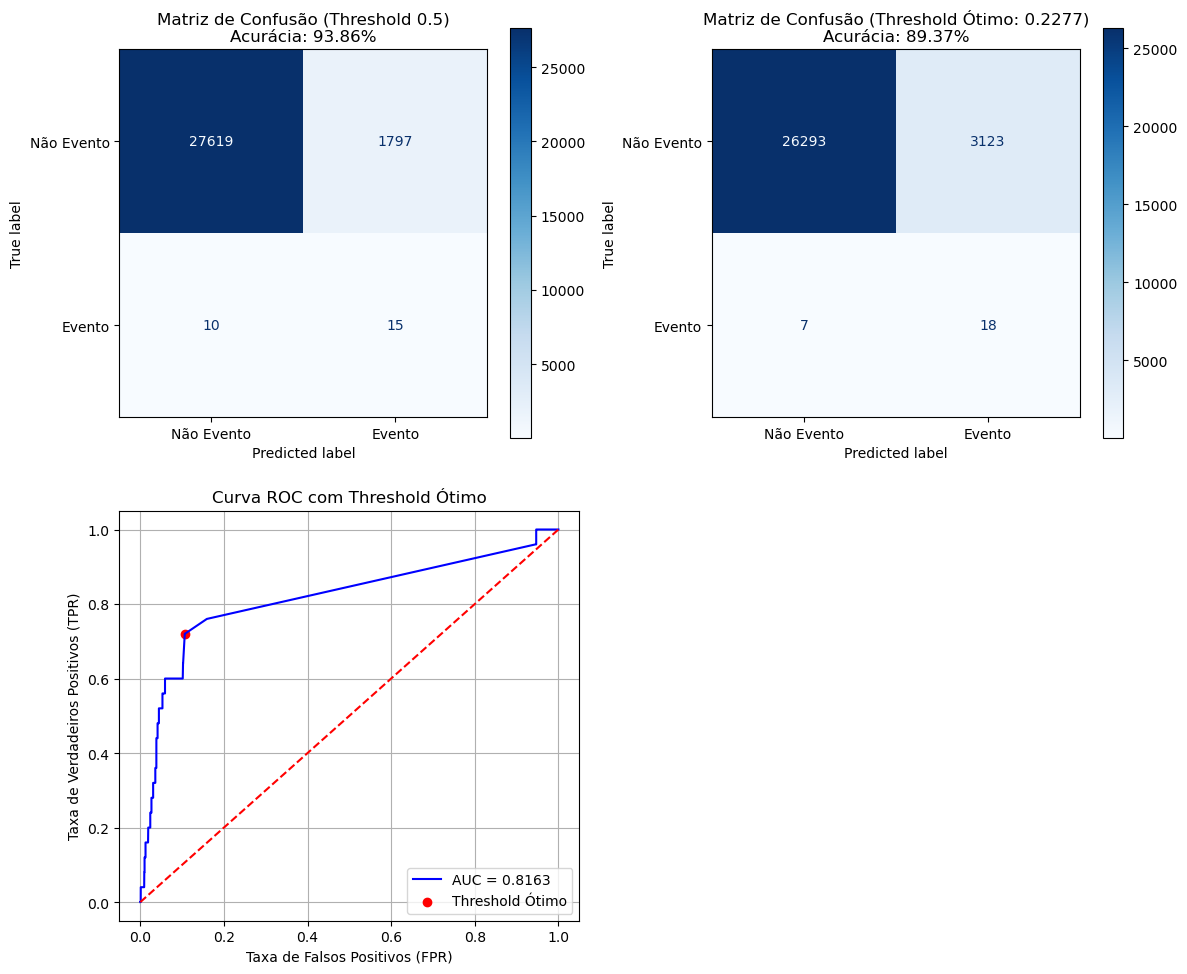

In [366]:
## Definir os parâmetros de timesteps e features
n_samples = X_train.shape[0]
timesteps = 5  # 1 valor atual + 4 lags
n_features = 4

# Reshape dos dados resampleados para CNN + LSTM (n_samples, timesteps, n_features)
n_samples_resampled = X_resampled.shape[0]
CNN1_X_train_reshaped = X_resampled.to_numpy().reshape((n_samples_resampled, timesteps, n_features))
n_samples_test = X_test.shape[0]
CNN1_X_test_reshaped = X_test.to_numpy().reshape((n_samples_test, timesteps, n_features))

# Definindo o diretório de logs para o Keras Tuner
log_dir = "Hyperband_" + f"{int(time.time())}"

# Função para construir o modelo
def build_model(hp):
    model = Sequential()

    model.add(Conv1D(filters=hp.Int("filter_first_layer", min_value=16, max_value=64, step=16),
                     kernel_size=hp.Int("kernel_first_layer", min_value=2, max_value=4, step=1),
                     activation='relu',
                     input_shape=(timesteps, n_features)))
    
    if hp.Boolean("use_batchnorm_1"):
        model.add(BatchNormalization())

    if hp.Boolean("use_MaxPooling1D"):
        model.add(MaxPooling1D(pool_size=2, name='Pooling1D_extra'))

    if hp.Boolean("use_LSTMExtra"):
        model.add(LSTM(units=hp.Int("lstmE_units", min_value=32, max_value=64, step=16), return_sequences=True, name='lstm_extra'))
    
    model.add(LSTM(units=hp.Int("lstm_units", min_value=32, max_value=64, step=16), return_sequences=False))
    
    model.add(Dropout(hp.Float("dropout_rate", 0.1, 0.5, step=0.1)))

    model.add(Dense(units=hp.Int("hidden_units", min_value=2, max_value=32, step=2)
                    , activation='relu'))  # Ativação sigmoide para classificação binária

    if hp.Boolean("use_dropout"):
        model.add(Dropout(hp.Float("dropoutE_rate", 0.1, 0.5, step=0.1)
                          , name='dropout_extra'))

    model.add(Dense(1, activation='sigmoid'))  # Ativação sigmoide para classificação binária
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auc'])
    return model

# Configurando o Keras Tuner
tuner = Hyperband(
    build_model,
    objective=['auc'],
    max_epochs=20,
    hyperband_iterations=3,
    directory=log_dir,
    project_name='cnn_lstm_tuning'
)


tuner.search(CNN1_X_train_reshaped, y_resampled, epochs=10, batch_size=32, validation_data=(CNN1_X_test_reshaped, y_test))
best_hyperparameters = tuner.get_best_hyperparameters()[0]
best_hyperparameters = pd.DataFrame(list(best_hyperparameters.values.items()), columns=['Hyperparameter', 'Value'])

# Avaliação do modelo com os melhores hiperparâmetros
CNN1_modelLSTM = tuner.get_best_models(num_models=1)[0]

# Avaliação do modelo
CNN1_loss, CNN1_AUC = CNN1_modelLSTM.evaluate(CNN1_X_test_reshaped, y_test)
print(f'Loss: {CNN1_loss}, AUC: {CNN1_AUC}')

# Fazer previsões
CNN1_y_pred_prob = CNN1_modelLSTM.predict(CNN1_X_test_reshaped)
CNN1_y_pred = (CNN1_y_pred_prob > 0.5).astype(int)

# Matriz de confusão com threshold padrão (0.5)
CNN1_cm_default = confusion_matrix(y_test, CNN1_y_pred)
CNN1_accuracy_default = accuracy_score(y_test, CNN1_y_pred)

# Curva ROC e AUC
CNN1_fpr, CNN1_tpr, CNN1_thresholds = roc_curve(y_test, CNN1_y_pred_prob)
CNN1_auc = roc_auc_score(y_test, CNN1_y_pred_prob)
print(f"AUC: {CNN1_auc:.4f}")

# Threshold ótimo
CNN1_optimal_idx = np.argmax(CNN1_tpr - CNN1_fpr)
CNN1_optimal_threshold = CNN1_thresholds[CNN1_optimal_idx]
print(f"Threshold ótimo: {CNN1_optimal_threshold:.4f}")

# Previsões com threshold otimizado
CNN1_y_pred_optimal = (CNN1_y_pred_prob >= CNN1_optimal_threshold).astype(int)
print(f'Recall Otimizado: {recall_score(y_test, CNN1_y_pred_optimal):.4f}')

# Matriz de confusão com threshold otimizado
CNN1_cm_optimal = confusion_matrix(y_test, CNN1_y_pred_optimal)
CNN1_accuracy_optimal = accuracy_score(y_test, CNN1_y_pred_optimal)

# Plotar matrizes de confusão e curva ROC
fig, axes = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1]})

# Matriz de confusão com threshold 0.5
CNN1_cm_display_default = ConfusionMatrixDisplay(confusion_matrix=CNN1_cm_default, display_labels=['Não Evento', 'Evento'])
CNN1_cm_display_default.plot(ax=axes[0, 0], cmap='Blues', values_format='d')
axes[0, 0].set_title(f'Matriz de Confusão (Threshold 0.5)\nAcurácia: {CNN1_accuracy_default * 100:.2f}%')

# Matriz de confusão com threshold otimizado
CNN1_cm_display_optimal = ConfusionMatrixDisplay(confusion_matrix=CNN1_cm_optimal, display_labels=['Não Evento', 'Evento'])
CNN1_cm_display_optimal.plot(ax=axes[0, 1], cmap='Blues', values_format='d')
axes[0, 1].set_title(f'Matriz de Confusão (Threshold Ótimo: {CNN1_optimal_threshold:.4f})\nAcurácia: {CNN1_accuracy_optimal * 100:.2f}%')

# Curva ROC com o threshold ótimo indicado
axes[1, 0].plot(CNN1_fpr, CNN1_tpr, color='blue', label=f'AUC = {CNN1_auc:.4f}')
axes[1, 0].scatter(CNN1_fpr[CNN1_optimal_idx], CNN1_tpr[CNN1_optimal_idx], marker='o', color='red', label='Threshold Ótimo')
axes[1, 0].plot([0, 1], [0, 1], color='red', linestyle='--')
axes[1, 0].set_xlabel('Taxa de Falsos Positivos (FPR)')
axes[1, 0].set_ylabel('Taxa de Verdadeiros Positivos (TPR)')
axes[1, 0].set_title('Curva ROC com Threshold Ótimo')
axes[1, 0].legend(loc='lower right')
axes[1, 0].grid()
fig.delaxes(axes[1, 1])
plt.tight_layout()
plt.show()

# Cenário 2 - Saltos temporais não removidos

## Aplicação do Optbinning (Information Value) e teste de Kolmogorov-Smirnov (KS) para seleção de features

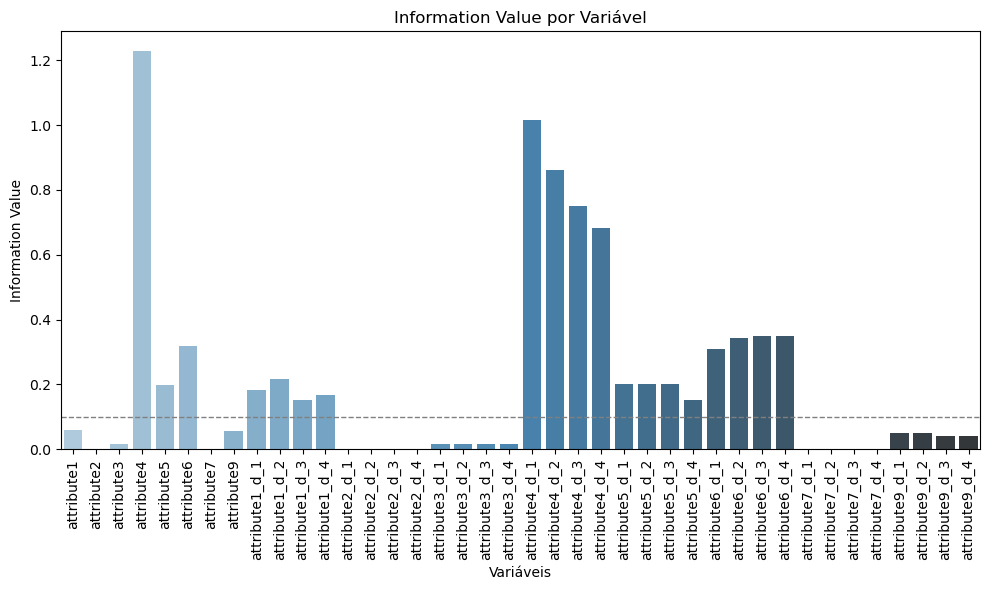

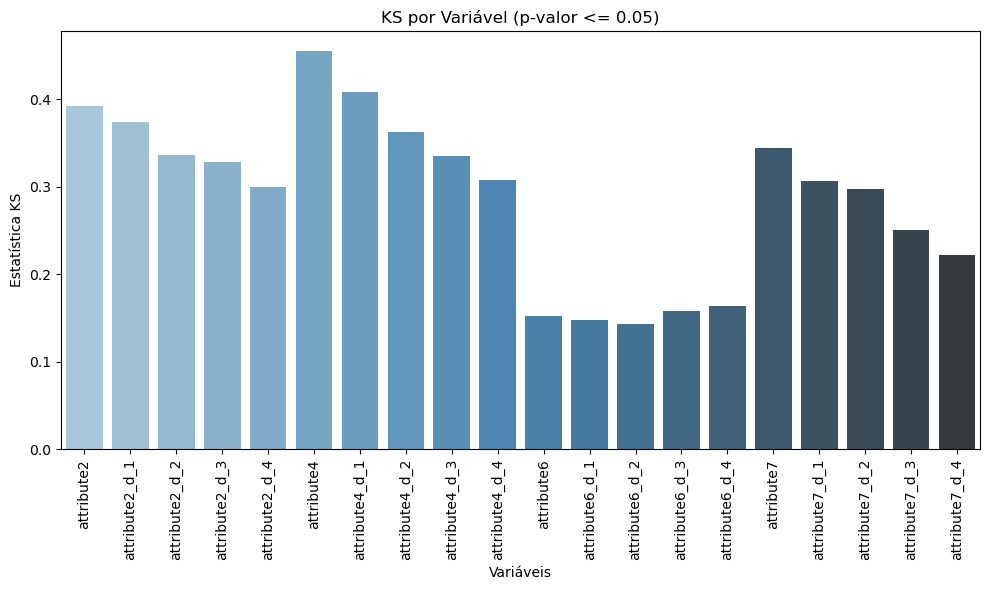

In [312]:
# Lista para armazenar os Information Values (IV) das variáveis
iv_values = []
variable_names = [item for item in df_cenario_2.columns if item.startswith('attribute')]

# Calcula o IV para cada variável
for i in range(len(variable_names)):
    iv = binning[i].binning_table.iv
    iv_values.append(iv)

# Criação do gráfico de barras para Information Value
plt.figure(figsize=(10, 6))
sns.barplot(x=variable_names, y=iv_values, palette="Blues_d")
plt.axhline(y=0.1, color='gray', linestyle='--', linewidth=1)
plt.xticks(rotation=90)
plt.title('Information Value por Variável')
plt.xlabel('Variáveis')
plt.ylabel('Information Value')
plt.tight_layout()

# Seleção de features usando o Teste de Kolmogorov-Smirnov
ks_var, ks_values, ks_p = [], [], []

for _var in vars:
    grupo_0 = df_cenario_2.loc[df_cenario_2["rolled_failure"] == 0, _var]
    grupo_1 = df_cenario_2.loc[df_cenario_2["rolled_failure"] == 1, _var]

    # Aplica o Teste de Kolmogorov-Smirnov
    ks_stat, p_value = stats.ks_2samp(grupo_0, grupo_1)
    
    if p_value <= 0.05:
        ks_var.append(_var)
        ks_values.append(ks_stat)
        ks_p.append(p_value)

# Criação do gráfico de barras para KS
plt.figure(figsize=(10, 6))
sns.barplot(x=ks_var, y=ks_values, palette="Blues_d")
plt.xticks(rotation=90)
plt.title('KS por Variável (p-valor <= 0.05)')
plt.xlabel('Variáveis')
plt.ylabel('Estatística KS')
plt.tight_layout()

# Exibe os gráficos
plt.show()

In [313]:
vars_escolhidas = ['attribute2', 'attribute2_d_1', 'attribute2_d_2', 'attribute2_d_3', 'attribute2_d_4',
         'attribute4', 'attribute4_d_1', 'attribute4_d_2', 'attribute4_d_3', 'attribute4_d_4',
         'attribute6', 'attribute6_d_1', 'attribute6_d_2', 'attribute6_d_3', 'attribute6_d_4',
         'attribute7', 'attribute7_d_1', 'attribute7_d_2', 'attribute7_d_3', 'attribute7_d_4']

## Amostragem com auxílio do KMeans e balanceamento dos dados (undersampling)

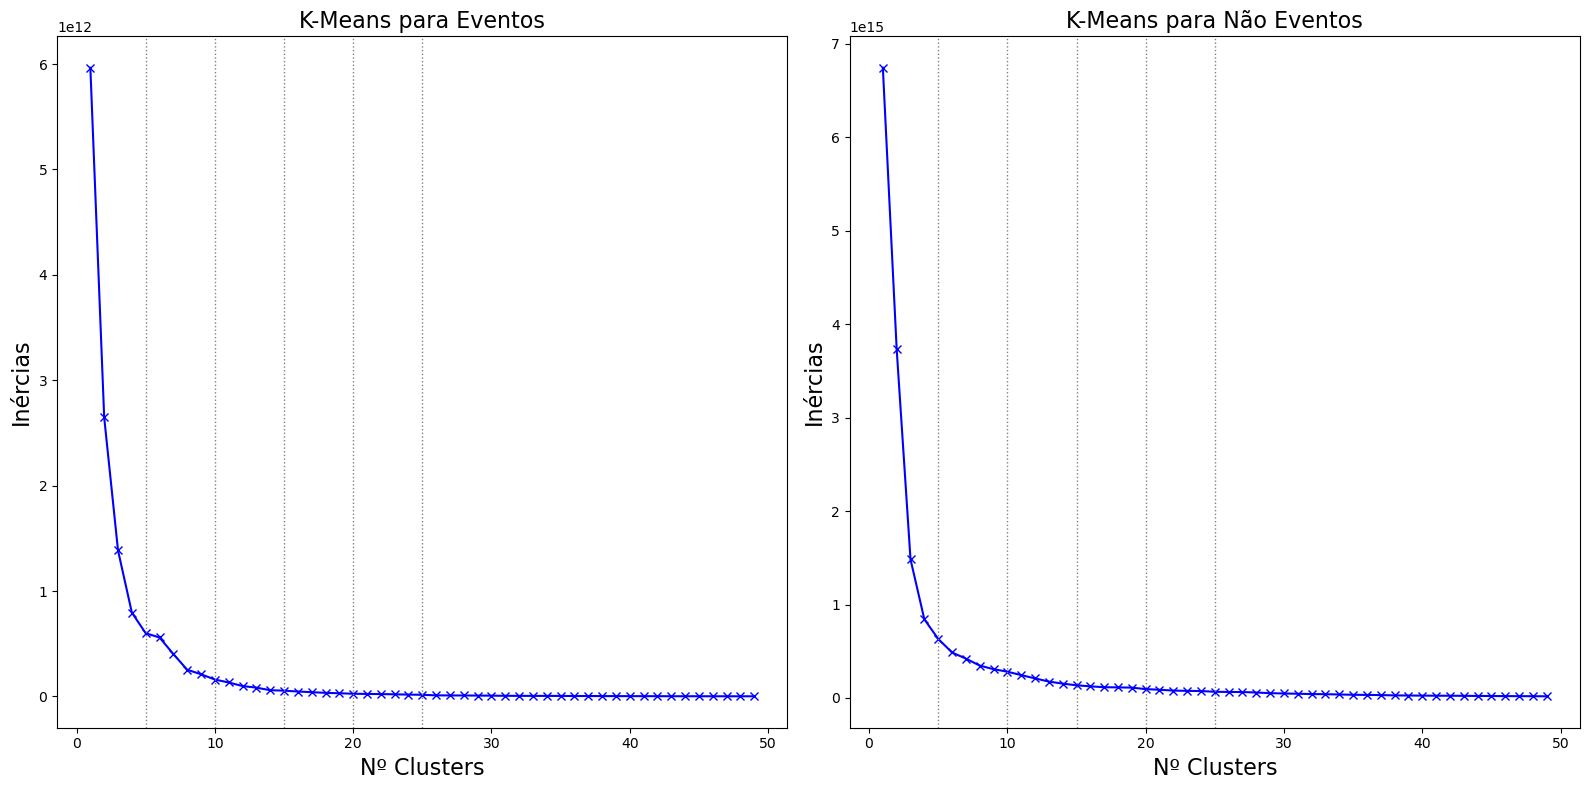

In [314]:
df_kmeans = df_cenario_2.copy()
df_eventos = df_kmeans.loc[df_kmeans['rolled_failure'] == 1,]
df_n_eventos = df_kmeans.copy().loc[df_kmeans['rolled_failure'] == 0,]

# Criar uma figura com 2 subplots lado a lado
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Lista de DataFrames e títulos para os gráficos
dataframes = [df_eventos, df_n_eventos]
titles = ['K-Means para Eventos', 'K-Means para Não Eventos']

for i, df in enumerate(dataframes):
    inercias = []
    K = range(1, 50)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=seed).fit(df[vars_escolhidas])
        inercias.append(kmeanModel.inertia_)
    
    # Plotar a inércia
    axs[i].plot(K, inercias, 'bx-')
    axs[i].axvline(x=5, color='grey', linestyle=':', linewidth=1)
    axs[i].axvline(x=10, color='grey', linestyle=':', linewidth=1)
    axs[i].axvline(x=15, color='grey', linestyle=':', linewidth=1)
    axs[i].axvline(x=20, color='grey', linestyle=':', linewidth=1)
    axs[i].axvline(x=25, color='grey', linestyle=':', linewidth=1)
    
    # Adicionar rótulos e título
    axs[i].set_xlabel('Nº Clusters', fontsize=16)
    axs[i].set_ylabel('Inércias', fontsize=16)
    axs[i].set_title(titles[i], fontsize=16)
plt.tight_layout()
plt.show()

In [367]:
#Balanceamento e separação dos conjuntos
clusters = 5

# Separar os eventos (failures) e não eventos
df_n_eventos = df_cenario_2.loc[df_cenario_2['rolled_failure'] == 0].copy()
df_eventos = df_cenario_2.loc[df_cenario_2['rolled_failure'] == 1].copy()

# Aplicar KMeans aos não eventos
kmeans_n_eventos = KMeans(n_clusters=clusters, random_state=seed).fit(df_n_eventos[vars_escolhidas])
df_n_eventos["clusters"] = kmeans_n_eventos.labels_

# Aplicar KMeans aos eventos
kmeans_eventos = KMeans(n_clusters=clusters, random_state=seed).fit(df_eventos[vars_escolhidas])
df_eventos["clusters"] = kmeans_eventos.labels_

# Dividir os eventos em treino (75%) e teste (25%)
df_eventos_teste = df_eventos.groupby('clusters', group_keys=False).apply(lambda x: x.sample(frac=0.25, random_state=seed))
df_eventos_treino = df_eventos.drop(df_eventos_teste.index)
df_eventos_teste = df_eventos_teste.drop(['clusters'], axis=1)
df_eventos_treino = df_eventos_treino.drop(['clusters'], axis=1)

# Dividir os não eventos em treino (75%) e teste (25%)
df_n_eventos_teste = df_n_eventos.groupby('clusters', group_keys=False).apply(lambda x: x.sample(frac=0.25, random_state=seed))
df_n_eventos_treino = df_n_eventos.drop(df_n_eventos_teste.index)
df_n_eventos_teste = df_n_eventos_teste.drop(['clusters'], axis=1)
df_n_eventos_treino = df_n_eventos_treino.drop(['clusters'], axis=1)

# Concatenar os dados de treino e teste
df_teste = pd.concat([df_n_eventos_teste, df_eventos_teste])
df_treino = pd.concat([df_n_eventos_treino, df_eventos_treino])

# Criação dos conjuntos
X_test = df_teste[vars_escolhidas]
y_test = df_teste['rolled_failure']

X_train = df_treino[vars_escolhidas]
y_train = df_treino['rolled_failure']

# Aplicar RandomUnderSampler para balancear a classe minoritária
undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state=seed)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

## XGBoosting

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Média da AUC ROC CV = 5: 0.8417 (±0.1035)
Acurácia de treino: 0.8009
Threshold ótimo: 0.3021
Recall Otimizado: 0.8519


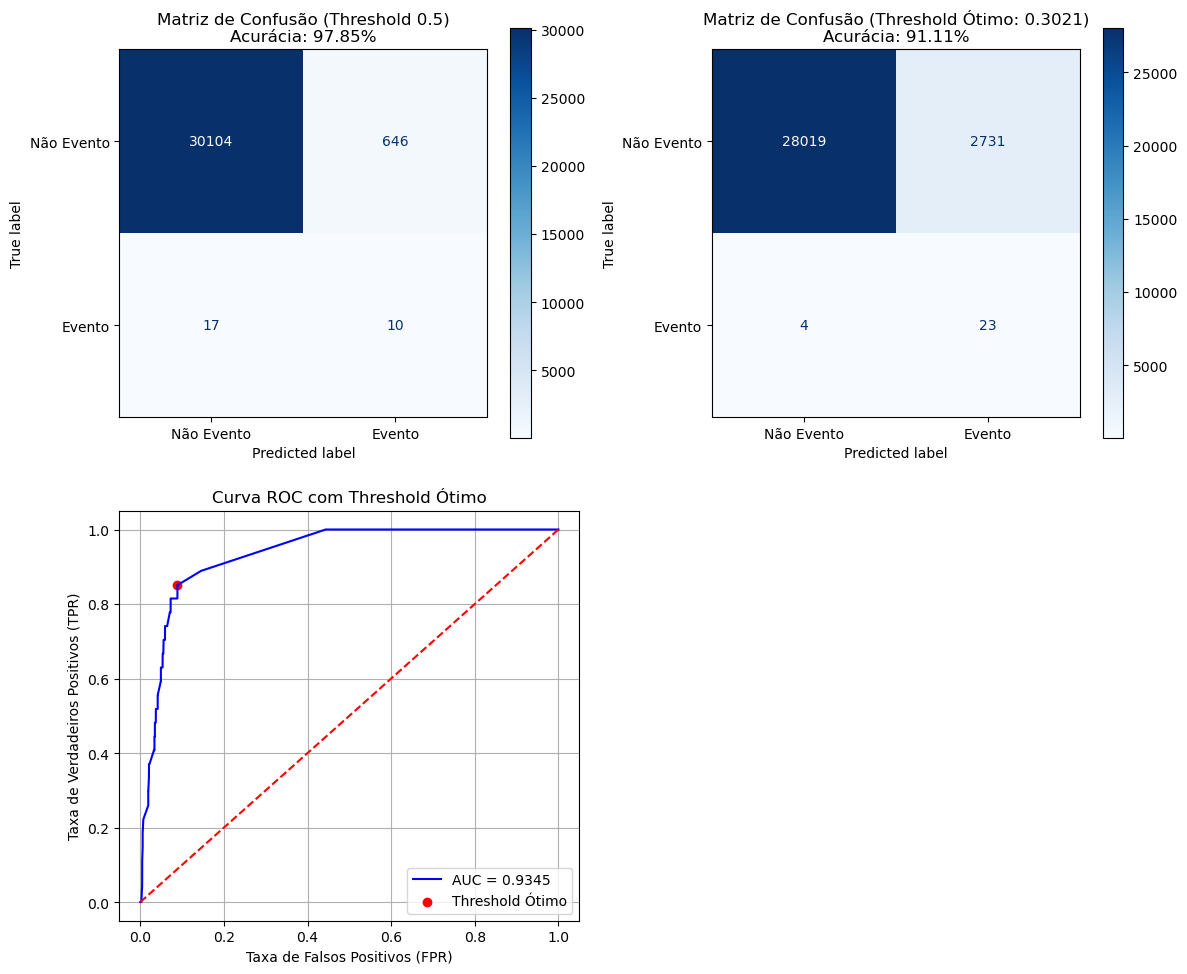

In [368]:
# Parâmetros para otimização
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}

# Instanciar o XGBoostClassifier
XGB2_model = XGBClassifier(random_state=seed)

# GridSearchCV para otimização de parâmetros
XGB2_grid_search = GridSearchCV(estimator=XGB2_model, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
XGB2_grid_search.fit(X_resampled, y_resampled)

# Obter o melhor modelo
XGB2_best_model = XGB2_grid_search.best_estimator_

# Avaliar a média e desvio padrão da AUC ROC para o melhor modelo
XGB2_mean_auc = XGB2_grid_search.cv_results_['mean_test_score'][XGB2_grid_search.best_index_]
XGB2_std_auc = XGB2_grid_search.cv_results_['std_test_score'][XGB2_grid_search.best_index_]

# Exibir resultados
print(f"Média da AUC ROC CV = 5: {XGB2_mean_auc:.4f} (±{XGB2_std_auc:.4f})")
print(f"Acurácia de treino: {XGB2_best_model.score(X_resampled, y_resampled):.4f}")

# Previsões no conjunto de teste com threshold padrão (0.5)
XGB2_y_pred = XGB2_best_model.predict(X_test)
XGB2_cm_default = confusion_matrix(y_test, XGB2_y_pred)
XGB2_accuracy_default = accuracy_score(y_test, XGB2_y_pred)

# Previsões de probabilidades no conjunto de teste
XGB2_y_prob = XGB2_best_model.predict_proba(X_test)[:, 1]
XGB2_fpr, XGB2_tpr, XGB2_thresholds = roc_curve(y_test, XGB2_y_prob)
XGB2_auc = roc_auc_score(y_test, XGB2_y_prob)

# Encontrar o threshold ótimo que maximiza a soma de TPR e (1-FPR)
XGB2_optimal_idx = np.argmax(XGB2_tpr - XGB2_fpr)
XGB2_optimal_threshold = XGB2_thresholds[XGB2_optimal_idx]
print(f"Threshold ótimo: {XGB2_optimal_threshold:.4f}")

# Previsões com o threshold otimizado
XGB2_y_pred_optimal = (XGB2_y_prob >= XGB2_optimal_threshold).astype(int)
XGB2_cm_optimal = confusion_matrix(y_test, XGB2_y_pred_optimal)
XGB2_accuracy_optimal = accuracy_score(y_test, XGB2_y_pred_optimal)
print(f'Recall Otimizado: {recall_score(y_test, XGB2_y_pred_optimal):.4f}')

# Criar subplots para exibir as matrizes de confusão e a curva ROC
XGB2_fig, XGB2_axes = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1]})

# Matriz de confusão com threshold 0.5
ConfusionMatrixDisplay(confusion_matrix=XGB2_cm_default, display_labels=['Não Evento', 'Evento']).plot(ax=XGB2_axes[0, 0], cmap='Blues', values_format='d')
XGB2_axes[0, 0].set_title(f'Matriz de Confusão (Threshold 0.5)\nAcurácia: {XGB2_accuracy_default * 100:.2f}%')

# Matriz de confusão com threshold otimizado
ConfusionMatrixDisplay(confusion_matrix=XGB2_cm_optimal, display_labels=['Não Evento', 'Evento']).plot(ax=XGB2_axes[0, 1], cmap='Blues', values_format='d')
XGB2_axes[0, 1].set_title(f'Matriz de Confusão (Threshold Ótimo: {XGB2_optimal_threshold:.4f})\nAcurácia: {XGB2_accuracy_optimal * 100:.2f}%')

# Curva ROC com o threshold ótimo
XGB2_axes[1, 0].plot(XGB2_fpr, XGB2_tpr, color='blue', label=f'AUC = {XGB2_auc:.4f}')
XGB2_axes[1, 0].scatter(XGB2_fpr[XGB2_optimal_idx], XGB2_tpr[XGB2_optimal_idx], marker='o', color='red', label='Threshold Ótimo')
XGB2_axes[1, 0].plot([0, 1], [0, 1], color='red', linestyle='--')
XGB2_axes[1, 0].set_xlabel('Taxa de Falsos Positivos (FPR)')
XGB2_axes[1, 0].set_ylabel('Taxa de Verdadeiros Positivos (TPR)')
XGB2_axes[1, 0].set_title('Curva ROC com Threshold Ótimo')
XGB2_axes[1, 0].legend(loc='lower right')
XGB2_axes[1, 0].grid()
XGB2_fig.delaxes(XGB2_axes[1, 1])
plt.tight_layout()
plt.show()

## Regressão Logística

Média da AUC ROC CV = 5: 0.7437 (±0.0713)
Acurácia de treino: 0.8312
Threshold ótimo: 0.4375
Recall Otimizado: 0.7778


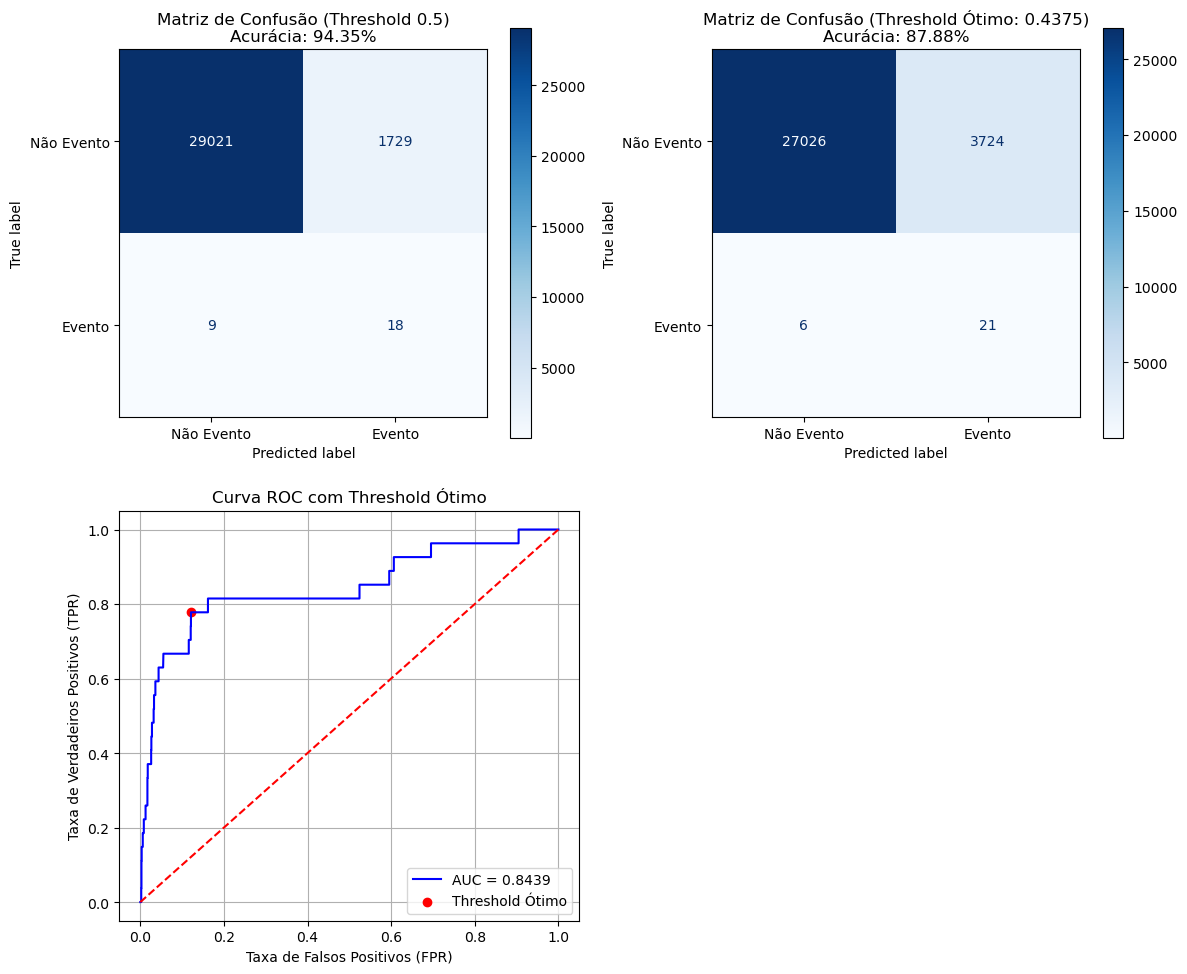

In [369]:
# Definir o modelo de regressão logística
LR2_model = LogisticRegression(random_state=seed, solver='liblinear', class_weight='balanced')

# Implementar K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
LR2_cross_val_scores = cross_val_score(LR2_model, X_resampled, y_resampled, cv=kf, scoring='roc_auc')

print(f"Média da AUC ROC CV = 5: {LR2_cross_val_scores.mean():.4f} (±{LR2_cross_val_scores.std():.4f})")

# Treinar o modelo no conjunto de dados resampled
LR2_model.fit(X_resampled, y_resampled)
LR2_y_pred = LR2_model.predict(X_test)

# Calcular a acurácia e exibir a matriz de confusão com threshold padrão (0.5)
LR2_cm_default = confusion_matrix(y_test, LR2_y_pred)
LR2_accuracy_default = accuracy_score(y_test, LR2_y_pred)

# Fazer previsões de probabilidades no conjunto de teste
LR2_y_prob = LR2_model.predict_proba(X_test)[:, 1]

# Calcular a curva ROC e AUC
LR2_fpr, LR2_tpr, LR2_thresholds = roc_curve(y_test, LR2_y_prob)
LR2_auc = roc_auc_score(y_test, LR2_y_prob)
print(f"Acurácia de treino: {LR2_model.score(X_resampled, y_resampled):.4f}")

# Encontrar o threshold ótimo
LR2_optimal_idx = np.argmax(LR2_tpr - LR2_fpr)
LR2_optimal_threshold = LR2_thresholds[LR2_optimal_idx]
print(f"Threshold ótimo: {LR2_optimal_threshold:.4f}")

# Fazer previsões com o threshold ótimo
LR2_y_pred_optimal = (LR2_y_prob >= LR2_optimal_threshold).astype(int)
print(f'Recall Otimizado: {recall_score(y_test, LR2_y_pred_optimal):.4f}')

# Calcular a acurácia e a matriz de confusão com o threshold otimizado
LR2_cm_optimal = confusion_matrix(y_test, LR2_y_pred_optimal)
LR2_accuracy_optimal = accuracy_score(y_test, LR2_y_pred_optimal)


fig, axes = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1]})

# Matriz de confusão com threshold 0.5
LR2_cm_display_default = ConfusionMatrixDisplay(confusion_matrix=LR2_cm_default, display_labels=['Não Evento', 'Evento'])
LR2_cm_display_default.plot(ax=axes[0, 0], cmap='Blues', values_format='d')
axes[0, 0].set_title(f'Matriz de Confusão (Threshold 0.5)\nAcurácia: {LR2_accuracy_default * 100:.2f}%')

# Matriz de confusão com threshold otimizado
LR2_cm_display_optimal = ConfusionMatrixDisplay(confusion_matrix=LR2_cm_optimal, display_labels=['Não Evento', 'Evento'])
LR2_cm_display_optimal.plot(ax=axes[0, 1], cmap='Blues', values_format='d')
axes[0, 1].set_title(f'Matriz de Confusão (Threshold Ótimo: {LR2_optimal_threshold:.4f})\nAcurácia: {LR2_accuracy_optimal * 100:.2f}%')

# Curva ROC com o threshold ótimo indicado
axes[1, 0].plot(LR2_fpr, LR2_tpr, color='blue', label=f'AUC = {LR2_auc:.4f}')
axes[1, 0].scatter(LR2_fpr[LR2_optimal_idx], LR2_tpr[LR2_optimal_idx], marker='o', color='red', label='Threshold Ótimo')
axes[1, 0].plot([0, 1], [0, 1], color='red', linestyle='--')  # Linha diagonal para comparação
axes[1, 0].set_xlabel('Taxa de Falsos Positivos (FPR)')
axes[1, 0].set_ylabel('Taxa de Verdadeiros Positivos (TPR)')
axes[1, 0].set_title('Curva ROC com Threshold Ótimo')
axes[1, 0].legend(loc='lower right')
axes[1, 0].grid()
fig.delaxes(axes[1, 1])
plt.tight_layout()
plt.show()

## CNN + LSTM Otimizada

Trial 90 Complete [00h 00m 40s]
multi_objective: -0.6165035963058472

Best multi_objective So Far: -0.8336987495422363
Total elapsed time: 00h 37m 15s
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - auc: 0.0028 - loss: 0.2581    
Loss: 0.2711557447910309, AUC: 0.8514230251312256
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
AUC: 0.8457
Threshold ótimo: 0.2552
Recall Otimizado: 0.7778


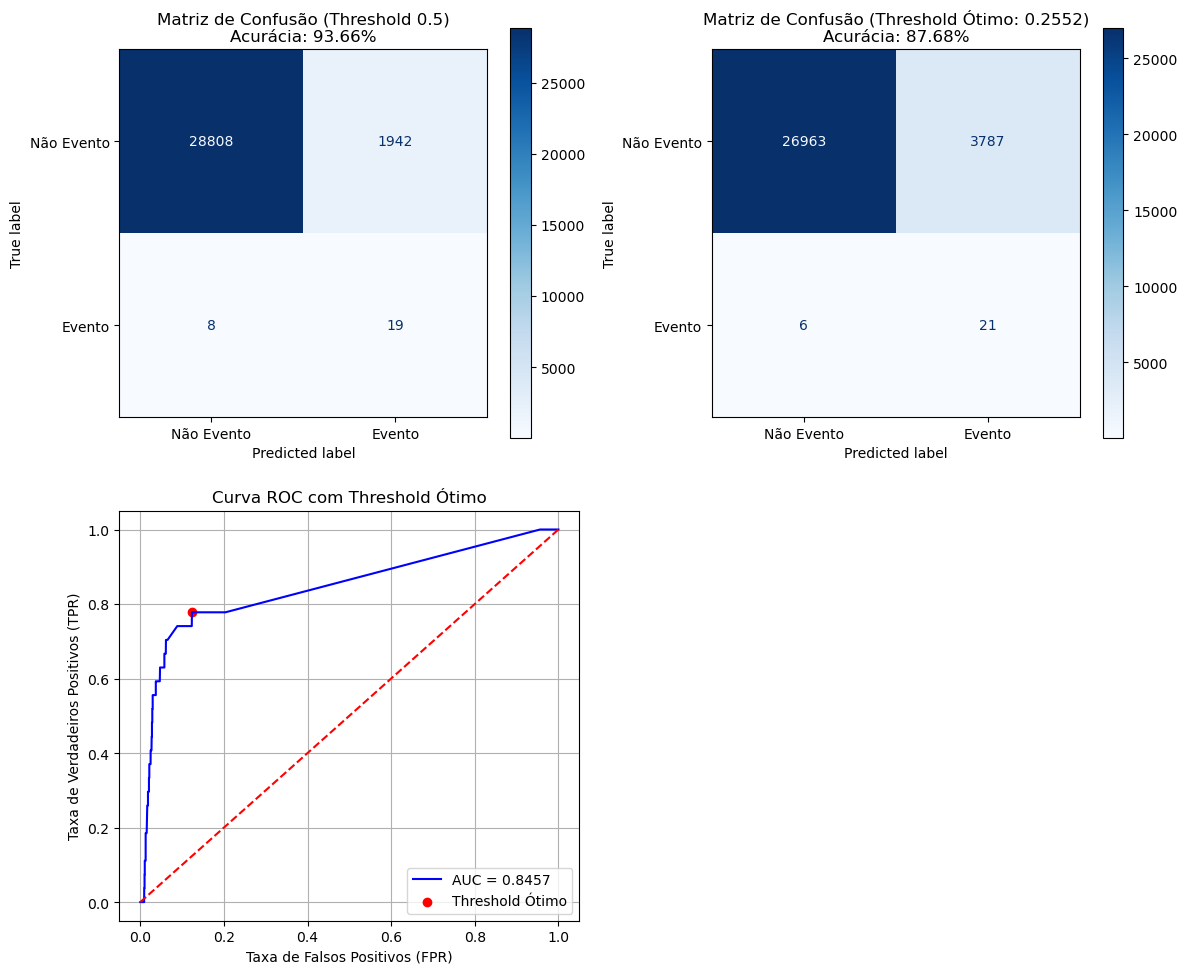

In [372]:
## Definir os parâmetros de timesteps e features
n_samples = X_train.shape[0]
timesteps = 5  # 1 valor atual + 4 lags
n_features = 4

# Reshape dos dados resampleados para CNN + LSTM (n_samples, timesteps, n_features)
n_samples_resampled = X_resampled.shape[0]
CNN2_X_train_reshaped = X_resampled.to_numpy().reshape((n_samples_resampled, timesteps, n_features))
n_samples_test = X_test.shape[0]
CNN2_X_test_reshaped = X_test.to_numpy().reshape((n_samples_test, timesteps, n_features))

# Definindo o diretório de logs para o Keras Tuner
log_dir = "Hyperband_" + f"{int(time.time())}"

# Função para construir o modelo
def build_model(hp):
    model = Sequential()

    model.add(Conv1D(filters=hp.Int("filter_first_layer", min_value=16, max_value=64, step=16),
                     kernel_size=hp.Int("kernel_first_layer", min_value=2, max_value=4, step=1),
                     activation='relu',
                     input_shape=(timesteps, n_features)))
    
    if hp.Boolean("use_batchnorm_1"):
        model.add(BatchNormalization())

    if hp.Boolean("use_MaxPooling1D"):
        model.add(MaxPooling1D(pool_size=2, name='Pooling1D_extra'))

    if hp.Boolean("use_LSTMExtra"):
        model.add(LSTM(units=hp.Int("lstmE_units", min_value=32, max_value=64, step=16), return_sequences=True, name='lstm_extra'))
    
    model.add(LSTM(units=hp.Int("lstm_units", min_value=32, max_value=64, step=16), return_sequences=False))
    
    model.add(Dropout(hp.Float("dropout_rate", 0.1, 0.5, step=0.1)))

    model.add(Dense(units=hp.Int("hidden_units", min_value=2, max_value=32, step=2)
                    , activation='relu'))  # Ativação sigmoide para classificação binária

    if hp.Boolean("use_dropout"):
        model.add(Dropout(hp.Float("dropoutE_rate", 0.1, 0.5, step=0.1)
                          , name='dropout_extra'))

    model.add(Dense(1, activation='sigmoid'))  # Ativação sigmoide para classificação binária
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auc'])
    return model

# Configurando o Keras Tuner
tuner = Hyperband(
    build_model,
    objective=['auc'],
    max_epochs=20,
    hyperband_iterations=3,
    directory=log_dir,
    project_name='cnn_lstm_tuning'
)


tuner.search(CNN2_X_train_reshaped, y_resampled, epochs=10, batch_size=32, validation_data=(CNN2_X_test_reshaped, y_test))
best_hyperparameters = tuner.get_best_hyperparameters()[0]
best_hyperparameters = pd.DataFrame(list(best_hyperparameters.values.items()), columns=['Hyperparameter', 'Value'])

# Avaliação do modelo com os melhores hiperparâmetros
CNN2_modelLSTM = tuner.get_best_models(num_models=1)[0]

# Avaliação do modelo
CNN2_loss, CNN2_AUC = CNN2_modelLSTM.evaluate(CNN2_X_test_reshaped, y_test)
print(f'Loss: {CNN2_loss}, AUC: {CNN2_AUC}')

# Fazer previsões
CNN2_y_pred_prob = CNN2_modelLSTM.predict(CNN2_X_test_reshaped)
CNN2_y_pred = (CNN2_y_pred_prob > 0.5).astype(int)

# Matriz de confusão com threshold padrão (0.5)
CNN2_cm_default = confusion_matrix(y_test, CNN2_y_pred)
CNN2_accuracy_default = accuracy_score(y_test, CNN2_y_pred)

# Curva ROC e AUC
CNN2_fpr, CNN2_tpr, CNN2_thresholds = roc_curve(y_test, CNN2_y_pred_prob)
CNN2_auc = roc_auc_score(y_test, CNN2_y_pred_prob)
print(f"AUC: {CNN2_auc:.4f}")

# Threshold ótimo
CNN2_optimal_idx = np.argmax(CNN2_tpr - CNN2_fpr)
CNN2_optimal_threshold = CNN2_thresholds[CNN2_optimal_idx]
print(f"Threshold ótimo: {CNN2_optimal_threshold:.4f}")

# Previsões com threshold otimizado
CNN2_y_pred_optimal = (CNN2_y_pred_prob >= CNN2_optimal_threshold).astype(int)
print(f'Recall Otimizado: {recall_score(y_test, CNN2_y_pred_optimal):.4f}')

# Matriz de confusão com threshold otimizado
CNN2_cm_optimal = confusion_matrix(y_test, CNN2_y_pred_optimal)
CNN2_accuracy_optimal = accuracy_score(y_test, CNN2_y_pred_optimal)

# Plotar matrizes de confusão e curva ROC
fig, axes = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1]})

# Matriz de confusão com threshold 0.5
CNN2_cm_display_default = ConfusionMatrixDisplay(confusion_matrix=CNN2_cm_default, display_labels=['Não Evento', 'Evento'])
CNN2_cm_display_default.plot(ax=axes[0, 0], cmap='Blues', values_format='d')
axes[0, 0].set_title(f'Matriz de Confusão (Threshold 0.5)\nAcurácia: {CNN2_accuracy_default * 100:.2f}%')

# Matriz de confusão com threshold otimizado
CNN2_cm_display_optimal = ConfusionMatrixDisplay(confusion_matrix=CNN2_cm_optimal, display_labels=['Não Evento', 'Evento'])
CNN2_cm_display_optimal.plot(ax=axes[0, 1], cmap='Blues', values_format='d')
axes[0, 1].set_title(f'Matriz de Confusão (Threshold Ótimo: {CNN2_optimal_threshold:.4f})\nAcurácia: {CNN2_accuracy_optimal * 100:.2f}%')

# Curva ROC com o threshold ótimo indicado
axes[1, 0].plot(CNN2_fpr, CNN2_tpr, color='blue', label=f'AUC = {CNN2_auc:.4f}')
axes[1, 0].scatter(CNN2_fpr[CNN2_optimal_idx], CNN2_tpr[CNN2_optimal_idx], marker='o', color='red', label='Threshold Ótimo')
axes[1, 0].plot([0, 1], [0, 1], color='red', linestyle='--')
axes[1, 0].set_xlabel('Taxa de Falsos Positivos (FPR)')
axes[1, 0].set_ylabel('Taxa de Verdadeiros Positivos (TPR)')
axes[1, 0].set_title('Curva ROC com Threshold Ótimo')
axes[1, 0].legend(loc='lower right')
axes[1, 0].grid()
fig.delaxes(axes[1, 1])
plt.tight_layout()
plt.show()

# Análise dos modelos e Considerações Finais

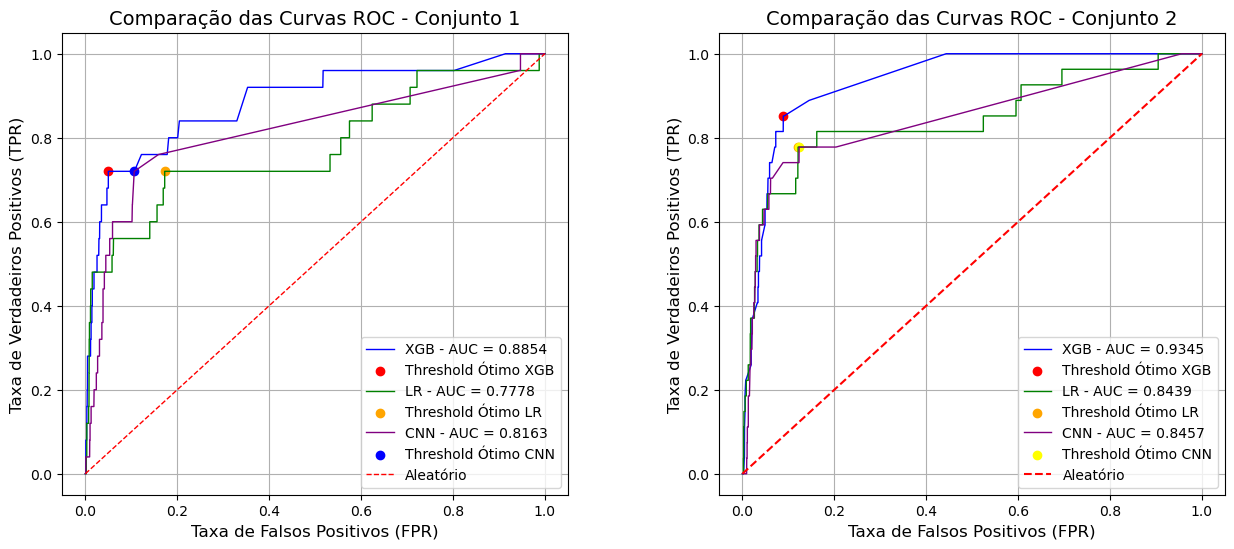


Matriz de métricas - Cenário 2


AUC-ROC  FalsePositiveRate  TruePositiveRate  Threshold
Modelo XGB    0.935              0.089             0.852      0.302
Modelo LR     0.844              0.054             0.630      0.438
Modelo CNN    0.846              0.123             0.778      0.255

In [448]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Curva ROC do cenário 1
axes[0].plot(XGB1_fpr, XGB1_tpr, color='blue', label=f'XGB - AUC = {XGB1_auc:.4f}', linewidth=1)
axes[0].scatter(XGB1_fpr[XGB1_optimal_idx], XGB1_tpr[XGB1_optimal_idx], marker='o', color='red', label='Threshold Ótimo XGB')
axes[0].plot(LR1_fpr, LR1_tpr, color='green', label=f'LR - AUC = {LR1_auc:.4f}', linewidth=1)
axes[0].scatter(LR1_fpr[LR1_optimal_idx], LR1_tpr[LR1_optimal_idx], marker='o', color='orange', label='Threshold Ótimo LR')
axes[0].plot(CNN1_fpr, CNN1_tpr, color='purple', label=f'CNN - AUC = {CNN1_auc:.4f}', linewidth=1)
axes[0].scatter(CNN1_fpr[CNN1_optimal_idx], CNN1_tpr[CNN1_optimal_idx], marker='o', color='blue', label='Threshold Ótimo CNN')
axes[0].plot([0, 1], [0, 1], color='red', linestyle='--', label='Aleatório', linewidth=1)
axes[0].set_xlabel('Taxa de Falsos Positivos (FPR)', fontsize=12)
axes[0].set_ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=12)
axes[0].set_title('Comparação das Curvas ROC - Conjunto 1', fontsize=14)
axes[0].legend(loc='lower right')
axes[0].grid()

# Curva ROC do cenário 2
axes[1].plot(XGB2_fpr, XGB2_tpr, color='blue', label=f'XGB - AUC = {XGB2_auc:.4f}', linewidth=1)
axes[1].scatter(XGB2_fpr[XGB2_optimal_idx], XGB2_tpr[XGB2_optimal_idx], marker='o', color='red', label='Threshold Ótimo XGB')
axes[1].plot(LR2_fpr, LR2_tpr, color='green', label=f'LR - AUC = {LR2_auc:.4f}', linewidth=1)
axes[1].scatter(LR2_fpr[LR2_optimal_idx], LR2_tpr[LR2_optimal_idx], marker='o', color='orange', label='Threshold Ótimo LR')
axes[1].plot(CNN2_fpr, CNN2_tpr, color='purple', label=f'CNN - AUC = {CNN2_auc:.4f}', linewidth=1)
axes[1].scatter(CNN2_fpr[CNN2_optimal_idx], CNN2_tpr[CNN2_optimal_idx], marker='o', color='yellow', label='Threshold Ótimo CNN')
axes[1].plot([0, 1], [0, 1], color='red', linestyle='--', label='Aleatório')
axes[1].set_xlabel('Taxa de Falsos Positivos (FPR)', fontsize=12)
axes[1].set_ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=12)
axes[1].set_title('Comparação das Curvas ROC - Conjunto 2', fontsize=14)
axes[1].legend(loc='lower right')
axes[1].grid()
plt.subplots_adjust(wspace=0.3)
plt.show()

modelos = ['Modelo XGB', 'Modelo LR', 'Modelo CNN']
metricas = ['AUC-ROC', 'FalsePositiveRate', 'TruePositiveRate', "Threshold"]

valores = [
    [XGB2_auc, XGB2_fpr[XGB2_optimal_idx], XGB2_tpr[XGB2_optimal_idx], XGB2_optimal_threshold], 
    [LR2_auc, LR2_fpr[XGB2_optimal_idx], LR2_tpr[XGB2_optimal_idx], LR2_optimal_threshold],
    [CNN2_auc, CNN2_fpr[CNN2_optimal_idx], CNN2_tpr[CNN2_optimal_idx], CNN2_optimal_threshold]
]

print("\nMatriz de métricas - Cenário 2")
display(round(pd.DataFrame(valores, index=modelos, columns=metricas),3))

Como demonstrado nas tabelas anteriores, os modelos desenvolvidos no cenário 2 (sem a remoção de observações com saltos temporais) apresentaram uma melhor capacidade de discriminar entre eventos e não eventos. Dessa forma, as próximas análises serão baseadas exclusivamente nos resultados do cenário 2.

Entre os modelos ajustados, o XGBoost apresentou os melhores índices de AUC-ROC e taxa de verdadeiros positivos, destacando-se como a escolha mais apropriada em comparação aos demais. No entanto, é importante considerar o impacto dos verdadeiros positivos, falsos positivos e falsos negativos. Embora essa informação específica não tenha sido fornecida no desafio, essa é uma discussão relevante em cenários reais. Vale a pena utilizar um modelo que identifica a maioria dos eventos de falha, mas gera muitos alarmes falsos? Na prática, isso dependerá do objetivo de negócio e dos custos envolvidos. Recomenda-se que o limiar de classificação seja ajustado considerando os pesos relativos de cada tipo de evento (falsos positivos, verdadeiros positivos, etc.), para garantir uma otimização alinhada aos resultados desejados.